In [15]:
import requests
import urllib
import urllib2
import community
import re
import networkx as nx
import matplotlib.pyplot as plt

In [16]:
# Query components
wikia = "http://lotr.wikia.com/"
api = "api.php?"
action = "action=query"
titles = ""
proprev = "&prop=revisions&rvprop=content"

In [17]:
# URL for retrieving all the characters
url = "http://lotr.wikia.com/api/v1/Articles/List&expand=1&category=Characters&limit=10000"
print "http://lotr.wikia.com/api.php?action=query&titles=Aragorn_II_Elessar&prop=revisions&rvprop=content"

# Getting the response from the URL and the JSON
r = requests.get(url)
response = r.json()

allUrls = []

# Adding to the URLs list and cleaning the data
for i in range(0, len(response['items'])):
    u = response['items'][i]['url']
    if "Category" not in u:
        allUrls.append(u)

#allUrls = allUrls[5:]
newOne = []
for au in allUrls:
    newOne.append(au.replace("/wiki/",""))

http://lotr.wikia.com/api.php?action=query&titles=Aragorn_II_Elessar&prop=revisions&rvprop=content


In [18]:
# Storing all the links
allLinks = []
for nextUrl in newOne:
    #allLinks.append(wikia+nextUrl+action)
    allLinks.append(wikia+api+action+"&titles="+nextUrl+proprev)
#for i in allLinks:
 #   print i

In [5]:
# Getting all the links for each character and writing them on file
index = 0
tempList = []
racesSet = set()
i = 0
namesAndRaces = []
for link in allLinks:
    # Opening file in Write mode
    #f = open("CharactersLinks/c"+str(index)+".txt", "w")
    # Reading the content of the link given
    m = urllib.urlopen(link.encode('utf-8')).read()
    if "Aragorn" in link:
        print "Index = ",index
    a = m.split('\n')
    for line in a:
        if "|race" in line or "| race" in line or "|Race" in line or "| Race" in line:
            r = re.findall(r'\[\[(.*?)\]\]', line)
            if len(r) > 0:
                e = r[0]
                namesAndRaces.append([newOne[i].encode('utf-8'),e])
                racesSet.add(e)
            break
            
    
    # Parsing the content of the link looking for links
    links = re.findall(r'\[\[(.*?)\]\]', m)
    # Cleaning the data
    #tempList = [x for x in links if "Category" not in x 
     #           and "dr" not in x 
      #          and "pl" not in x 
       #         and "ru" not in x 
        #        and "pt-br" not in x 
         #       and "nl" not in x 
          #      and "it" not in x
           #     and "de" not in x]
    # Writing on file all the links remained
    #print tempList
    #for i in tempList:
      #  f.write(i+"\n")
    # Closing file
    #f.close()
    # Increasing index for the next file
    index += 1
    i += 1

print "Number of races:",len(racesSet)

Index =  49
Index =  50
Number of races: 40


In [19]:
# Saving the names and races set
temp = namesAndRaces

In [20]:
# Cleaning the data and grouping the races which are written in different ways but which indicate the same race.
for i in namesAndRaces:
    if "Dwarven" in i[1] or "Dwarf" in i[1]:
        i[1] = "Dwarves"
        if "Dwarven" in racesSet or "Dwarf" in racesSet:
            racesSet.remove("Dwarven")
            racesSet.remove("Dwarf")
    if "Hobbit" in i[1] or "Hobbits|Hobbit" in i[1]:
        i[1] = "Hobbits"
        if "Hobbit" in racesSet:
            racesSet.remove("Hobbit")
        if "Hobbits|Hobbit" in racesSet:
            racesSet.remove("Hobbits|Hobbit")
    if "Dragon" in i[1]:
        i[1] = "Dragons"
        if "Dragon" in racesSet:
            racesSet.remove("Dragon")
    if "Man" in i[1]:
        i[1] = "Men"
        if "Man" in racesSet:
            racesSet.remove("Man")
    if "File" in i[1]:
        toDelete = i
    if "Orc" in i[1]:
        i[1] = "Orcs"
        if "Orc" in racesSet:
            racesSet.remove("Orc")
    if "Elf" in i[1]:
        i[1] = "Elves"
        if "Elf" in racesSet:
            racesSet.remove("Elf")

if toDelete in namesAndRaces:
    namesAndRaces.remove(toDelete)

In [21]:
wikia = "http://lotr.wikia.com/"
api = "api.php?"
action = "action=query"
titles = ""
prop = "links"
proprev = "rvprop=content"

In [22]:
newlink =  "http://lotr.wikia.com/api.php?action=query&titles=Aragorn_II_Elessar&prop=links&rvprop=content&pllimit=500&format=json"

In [23]:
myLinks = []
for nextName in newOne:
    myLinks.append(wikia+api+action+"&titles="+nextName+"&"+"prop="+prop+"&"+proprev+"&pllimit=500&format=json")

In [24]:
#index = 0
#for link in myLinks:
 #   print link
  #  print "Name: "+newOne[index]
   # r = requests.get(link)
    #response = r.json()
  #  rep = response['query']['pages'].values()[0]
   # if "/" not in newOne[index] and ":" not in newOne[index]:
    #    f = open("NewCharsLinks/"+str(newOne[index])+".txt", "w")
     #   if 'links' in rep:
      #      linksInPage = rep.get('links')
       #     for l in linksInPage:
        #        charName = l['title']
         #       charName = charName.encode('utf-8')
          #      charName = charName.replace(" ", "_")
           #     f.write(charName+"\n")
#        f.close()
 #   index+=1

In [25]:
print index

0


In [27]:
index = 0
G2 = nx.DiGraph()
tempG = nx.DiGraph()

#G.add_nodes_from(namesAndRaces)
for n in namesAndRaces:
    G2.add_node(n[0])
count = 0
for fileNumber in range(0, len(namesAndRaces)):
    if "/" not in namesAndRaces[fileNumber][0] and ":" not in namesAndRaces[fileNumber][0]:
        f = open("NewCharsLinks/"+str(namesAndRaces[fileNumber][0])+".txt", "r")
        charLinks = f.read().split("\n")

        for link in charLinks:
            link = link.replace("\r","")
            for name in namesAndRaces:
                if link == name[0]:
                    firstChar = namesAndRaces[fileNumber][0]
                    secondChar = link
                    c1 = ""
                    c2 = ""
                    for i in G2.nodes():
                        if i == firstChar:
                            c1 = i
                        elif i == secondChar:
                            c2 = i
                    G2.add_edge(c1, c2)


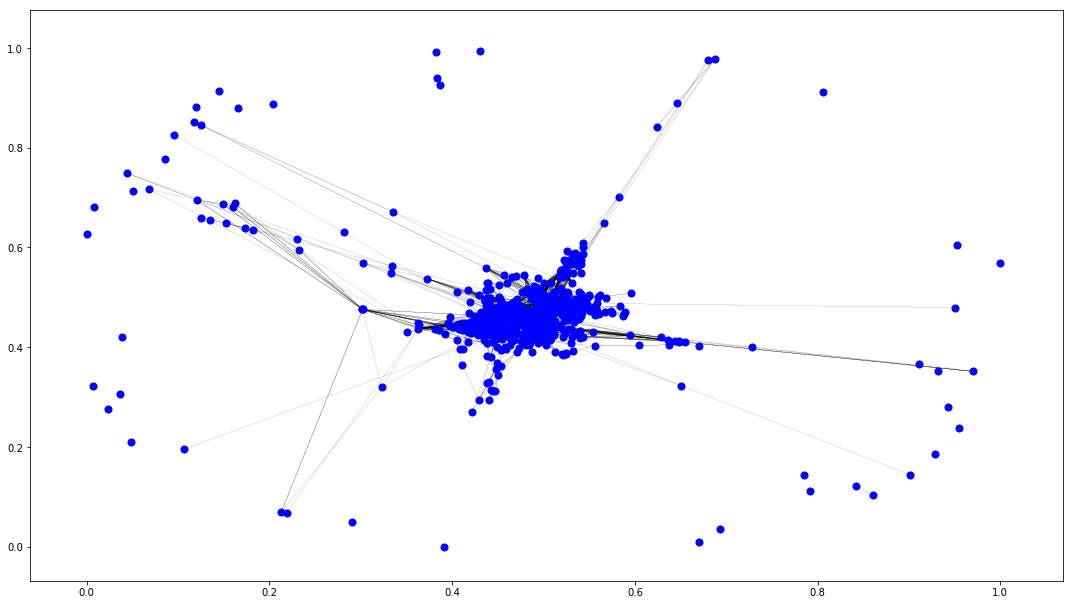

In [28]:
# Drawing the graph with a spring_layout
pos = nx.spring_layout(G2)
nx.draw_networkx_nodes(G2, pos, node_color = 'b', node_size = 50, width=100)
nx.draw_networkx_edges(G2, pos, arrows=False, width=0.1)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [57]:
def drawCustomGraph(g):
    pos = nx.spring_layout(g,k=0.30,iterations=70, scale=2)
    
    nx.draw_networkx_nodes(g,pos=pos,nodelist=halfeleven, node_color='blue', label='Half-Elven', node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=horse, node_color='green', label='Horses',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=hobbits, node_color='red', label='Hobbits',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=urukhai, node_color='yellow', label='Uruk-Hai',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=god, node_color='purple', label='God',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=vampire, node_color='grey', label='Vampires',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=eagles, node_color='orange', label='Eagles',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=blackuruk, node_color='black', label='Black Uruk',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=men, node_color='pink', label='Men',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=ainur, node_color='turquoise', label='Ainur',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=goblin, node_color='crimson', label='Goblins',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=skinchanger, node_color='indigo', label='Skin-Changer',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=greateagles, node_color='magenta', label='Great Eagles',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=maiar, node_color='navy', label='Maiar',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=orcs, node_color='violet', label='Orcs',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=werewolves, node_color='teal', label='Werewolves',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=druedain, node_color='snow', label='Druedain',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=unknown, node_color='silver', label='Unknown',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=uruoloki, node_color='salmon', label='Uruloki',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=stonetrolls, node_color='maroon', label='Stone-Trolls',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=dwarves, node_color='brown', label='Dwarves',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=balrog, node_color='lime', label='Balrog',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=dragons, node_color='gold', label='Dragons',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=ents, node_color='ivory', label='Ents',node_size=17)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=greatspiders, node_color='fuchsia', label='Great Spiders',node_size=17)

    nx.draw_networkx_edges(g, pos)

    plt.legend()

    # Saving graph in the main folder of the project
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('newGraph.pdf', dpi=100)

    plt.show()
    

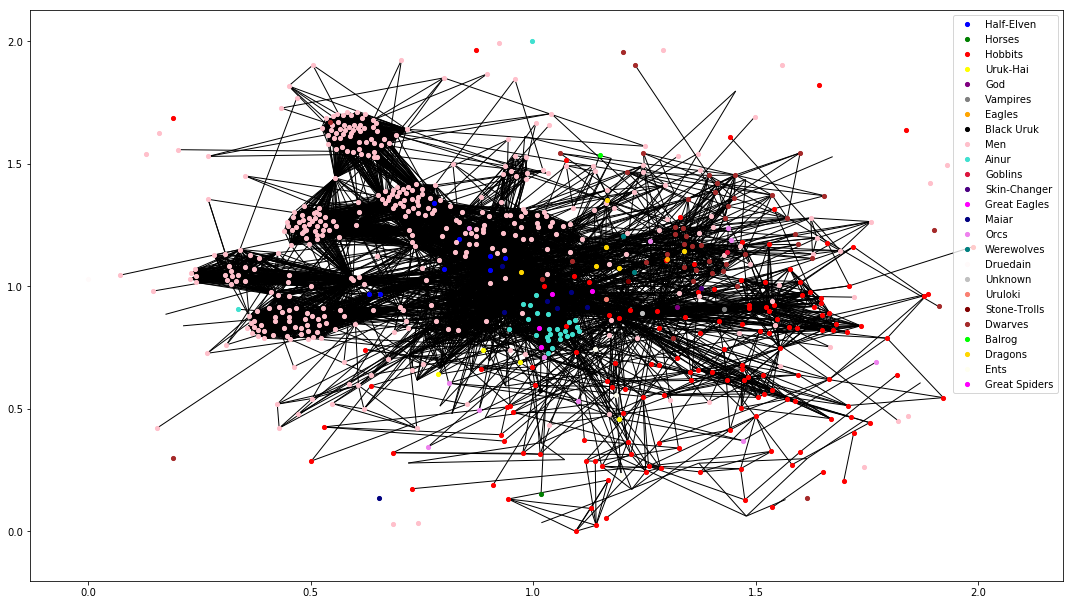

In [76]:
# Getting the undirected version of the graph for further analysis
UG2 = G2.to_undirected()

halfeleven = []
horse = []
hobbits = []
urukhai = []
god = []
vampire = []
eagles = []
blackuruk = []
men = []
ainur = []
goblin = []
skinchanger = []
greateagles = []
maiar = []
orcs = []
werewolves = []
druedain = []
unknown = []
uruoloki = []
stonetrolls = []
dwarves = []
balrog = []
dragons = []
ents = []
greatspiders = []

color_map = []
for node in UG2:
    for item in namesAndRaces:
        if item[0] == node:
            if item[1] == "Half-elven":
                color_map.append("blue")
                halfeleven.append(node)
            elif item[1] == "Horse":
                color_map.append("green")
                horse.append(node)
            elif item[1] == "Hobbits":
                color_map.append("red")
                hobbits.append(node)
            elif item[1] == "Uruk-hai":
                color_map.append("yellow")
                urukhai.append(node)
            elif item[1] == "God":
                color_map.append("purple")
                god.append(node)
            elif item[1] == "Vampire":
                color_map.append("grey")
                vampire.append(node)
            elif item[1] == "Eagles":
                color_map.append("orange")
                eagles.append(node)
            elif item[1] == "Black Uruk":
                color_map.append("black")
                blackuruk.append(node)
            elif item[1] == "Men":
                color_map.append("pink")
                men.append(node)
            elif item[1] == "Ainur":
                color_map.append("turquoise")
                ainur.append(node) 
            elif item[1] == "Goblin":
                color_map.append("crimson")
                goblin.append(node)
            elif item[1] == "Skin-changer":
                color_map.append("indigo")
                skinchanger.append(node)
            elif item[1] == "Great Eagles":
                color_map.append("magenta")
                greateagles.append(node)
            elif item[1] == "Maiar":
                color_map.append("navy")
                maiar.append(node)
            elif item[1] == "Orcs":
                color_map.append("violet")
                orcs.append(node)
            elif item[1] == "Werewolves":
                color_map.append("teal")
                werewolves.append(node)
            elif item[1] == "Drúedain":
                color_map.append("snow")
                druedain.append(node)
            elif item[1] == "Theories about Tom Bombadil|Unknown":
                color_map.append("silver")
                unknown.append(node)
            elif item[1] == "Urulóki":
                color_map.append("salmon")
                uruoloki.append(node)
            elif item[1] == "Stone-trolls":
                color_map.append("maroon")
                stonetrolls.append(node)
            elif item[1] == "Dwarves":
                color_map.append("brown")
                dwarves.append(node)
            elif item[1] == "Balrog":
                color_map.append("lime")
                balrog.append(node)
            elif item[1] == "Dragons":
                color_map.append("gold")
                dragons.append(node)
            elif item[1] == "Ents":
                color_map.append("ivory")
                ents.append(node)
            elif item[1] == "Great Spiders":
                color_map.append("fuchsia")
                greatspiders.append(node)
        
drawCustomGraph(UG2)


In [62]:
def cleanAfterGCC(g):
    for he in halfeleven:
        if he not in g:
            halfeleven.remove(he)
    for h in horse:
        if h not in g:
            horse.remove(h)
    for hobbit in hobbits:
        if hobbit not in g:
            hobbits.remove(hobbit)
    for uruk in urukhai:
        if uruk not in g:
            urukhai.remove(uruk)
    for g in god:
        if g not in g:
            god.remove(g)
    for vamp in vampire:
        if vamp not in g:
            vampire.remove(vamp)
    for ea in eagles:
        if ea not in g:
            eagles.remove(ea)
    for blackur in blackuruk:
        if blackur not in g:
            blackuruk.remove(blackur)
    for man in men:
        if man not in g:
            men.remove(man)
    for ain in ainur:
        if ain not in g:
            ainur.remove(ain)
    for gobl in goblin:
        if gobl not in g:
            goblin.remove(gobl)
    for sc in skinchanger:
        if sc not in g:
            skinchanger.remove(sc)
    for ge in greateagles:
        if ge not in g:
            greateagles.remove(ge)
    for mai in maiar:
        if mai not in g:
            maiar.remove(mai)
    for orc in orcs:
        if orc not in g:
            orcs.remove(orc)
    for ww in werewolves:
        if ww not in g:
            werewolves.remove(ww)
    for dru in druedain:
        if dru not in g:
            druedain.remove(dru)
    for unk in unknown:
        if unk not in g:
            unknown.remove(unk)
    for urul in uruoloki:
        if urul not in g:
            uruoloki.remove(urul)
    for st in stonetrolls:
        if st not in g:
            stonetrolls.remove(st)
    for dwarf in dwarves:
        if dwarf not in g:
            dwarves.remove(dwarf)
    for balr in balrog:
        if balr not in g:
            balrog.remove(balr)
    for dragon in dragons:
        if dragon not in g:
            dragons.remove(dragon)
    for ent in ents:
        if ent not in g:
            ents.remove(ent)

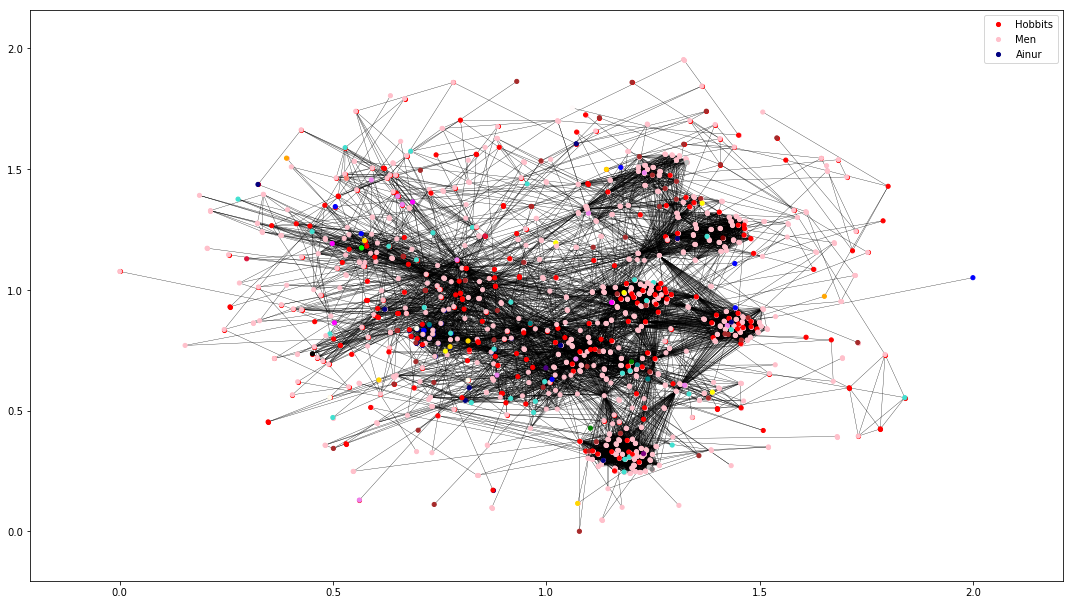

In [80]:
# Retrieving the GCC
GCC2 = max(nx.connected_component_subgraphs(UG2), key=len)

pos = nx.spring_layout(GCC2,k=0.30,iterations=70, scale=2)
 #node_color=color_map, with_labels=True, node_size=17)

hbs = []
men2 = []
ainurs = []
for hobbit in hobbits:
    if hobbit in GCC2:
        hbs.append(hobbit)
for m in men:
    if m in GCC2:
        men2.append(m)
for ain in ainur:
    if ain in GCC2:
        ainurs.append(ain)

nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=hbs, node_color='red', label='Hobbits',node_size=17)
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=men2, node_color='pink', label='Men',node_size=17)
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=ainurs, node_color='navy', label='Ainur',node_size=17)
nx.draw_networkx_nodes(GCC2, pos,node_color=color_map,with_labels=True, node_size=17) #node_color=color_map, with_labels=True, node_size=17)

plt.legend()

nx.draw_networkx_edges(GCC2, pos, width=0.3)

# Saving graph in the main folder of the project
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('graphNew.png', dpi=100)

plt.show()

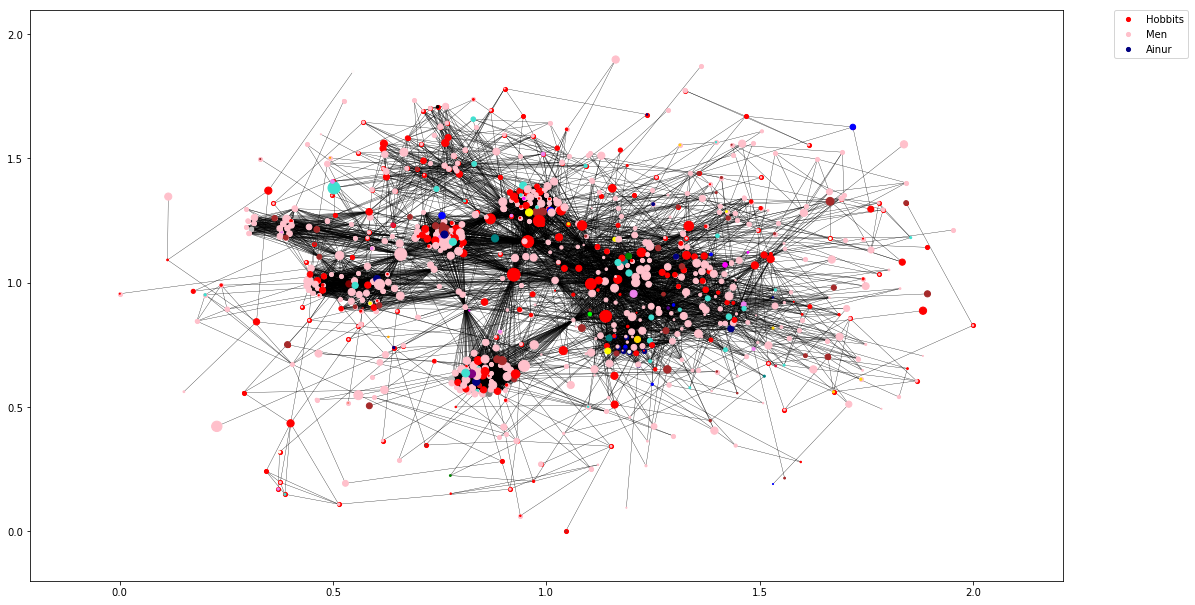

In [83]:
allDegreesDiGraph = nx.degree(GCC2)
pos = nx.spring_layout(GCC2,k=0.30,iterations=70, scale=2)

nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=hbs, node_color='red', label='Hobbits',node_size=17)
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=men2, node_color='pink', label='Men',node_size=17)
nx.draw_networkx_nodes(GCC2,pos=pos,nodelist=ainurs, node_color='navy', label='Ainur',node_size=17)

nx.draw_networkx_nodes(GCC2, pos,node_color=color_map,with_labels=True, node_size=[v * 1.1 for v in allDegreesDiGraph.values()]) #node_color=color_map, with_labels=True, node_size=17)
nx.draw_networkx_edges(GCC2, pos, width=0.3)

plt.legend()

# Saving graph in the main folder of the project
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('graphNew.png', dpi=100)

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [84]:
#first compute the best partition
partition = community.best_partition(GCC2)

#drawing
size = float(len(set(partition.values())))

# Printing out the modularity of the best partition retrieved
print "Modularity retrieved by the Louvain Algorithm: ",community.modularity(partition,GCC2)



Modularity retrieved by the Louvain Algorithm:  0.709687147662


In [85]:
# Instantiating an empty dictionary for the races
communities = {}
# Instantiating an empty list 
newList = []
# Grouping all the characters belonging to different communities 
for i,j in partition.iteritems():
    if j not in communities:
        communities[j] = []
    else:
        currentList = communities.get(j)
        currentList.append(i)
        communities[j] = currentList


In [86]:
print "Most populated community:", max([(k, len(v)) for (k,v) in communities.items()], key=lambda (k,v): v)

Most populated community: (2, 230)


In [87]:
# Let's find the top 10 characters by in-degree first, and then by out-degree.
allInDegree = {}
allOutDegree = {}

for char in G2.nodes():
    allInDegree[char] = G2.in_degree(char)
    allOutDegree[char] = G2.out_degree(char)
    
print "Top 10 by In-Degree:",sorted(allInDegree, key=allInDegree.get, reverse=True)[:10]
print "Top 10 by Out-Degree:",sorted(allOutDegree, key=allOutDegree.get, reverse=True)[:10]

Top 10 by In-Degree: ['Faramir', 'Sauron', 'Isildur', 'Elendil', 'Elros', 'Elrond', 'Gandalf', 'Eldarion', 'Cemendur', 'Aragorn_II_Elessar']
Top 10 by Out-Degree: ['Aragorn_II_Elessar', 'Elendil', 'Eldarion', 'Isildur', 'Argonui', 'Gandalf', 'Aranarth', 'Araphor', 'Arassuil', 'Arathorn_II']


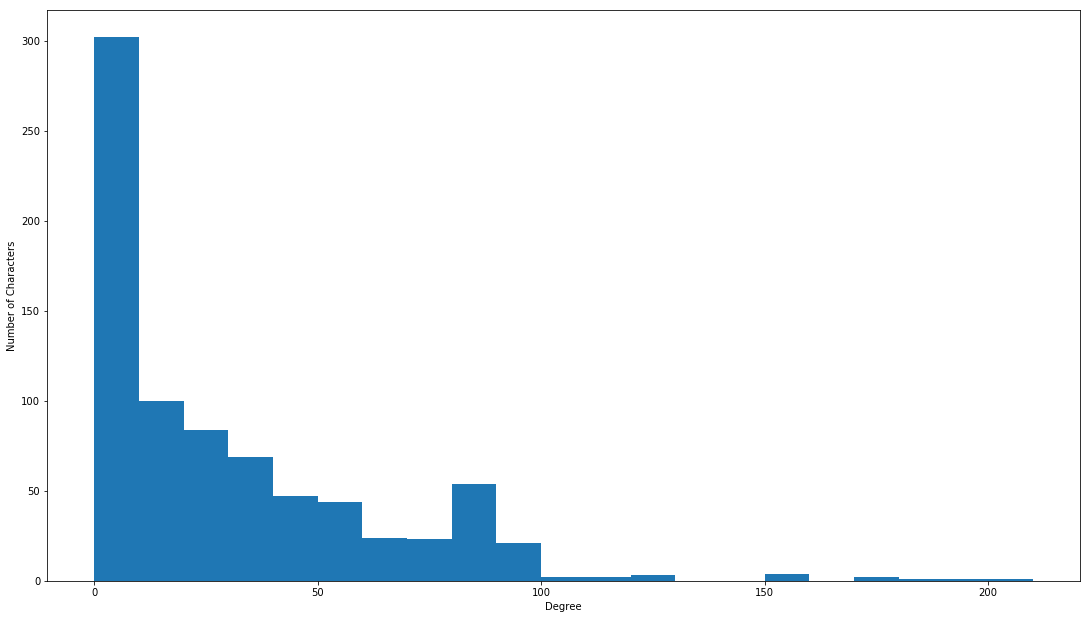

In [88]:
# Let's see a histogram of the degree distribution.
plt.hist(nx.degree(G2).values(), bins=range(min(nx.degree(G2).values()), max(nx.degree(G2).values()) + 10, 10))
plt.xlabel('Degree')
plt.ylabel('Number of Characters')
plt.savefig('network_degree.png')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('graphNew.png', dpi=100)
plt.show()